In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from BuildingOccupancy import Person, Meeting, WeeklyMeeting, OneTimeMeeting, BuildingOccupancy
from DefaultBuildings import Building_5ZoneAirCooled
from Agents import agent_constructor
from CentralController import ddpg_episode_mc
import RLCritics
import StateUtilities as SU

In [4]:
import visualization_helper as vh

In [5]:
dirname1 = '../checkpoints/b011/' # baseline chicago
dirname2 = '../checkpoints/b012/' # baseline chicago; changed setpoints
dirname3 = '../checkpoints/b001/' # baseline fairfax

In [6]:
dfs1 = vh.convert_sqlite_to_df(dirname1)
dfs2 = vh.convert_sqlite_to_df(dirname2)
dfs3 = vh.convert_sqlite_to_df(dirname3)

Table eees convertet to a pandas dataframe.
Table eeesea convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eees convertet to a pandas dataframe.
Table eeesea convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eees convertet to a pandas dataframe.
Table eeesea convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


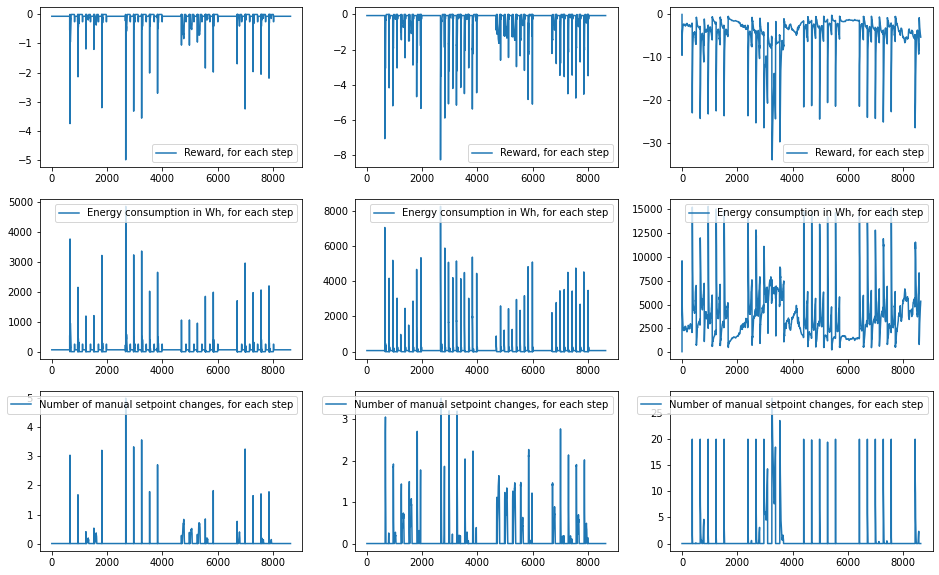

In [7]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,10), sharex=False)
vh.plot_eees_normal(dfs1, axes[:, 0])
vh.plot_eees_normal(dfs2, axes[:, 1])
vh.plot_eees_normal(dfs3, axes[:, 2])

<h3>Details: Temperatur Setpoints</h3>

In [10]:
selected_episode = 0
selected_week    = datetime.datetime(2017, 7, 1)
selected_week2   = datetime.datetime(2017, 7, 1)
selected_week3   = datetime.datetime(2017, 1, 1)

subdfs1 = vh.select_week_and_episode(dfs1, selected_episode, selected_week)
subdfs2 = vh.select_week_and_episode(dfs2, selected_episode, selected_week2)
subdfs3 = vh.select_week_and_episode(dfs3, selected_episode, selected_week3)

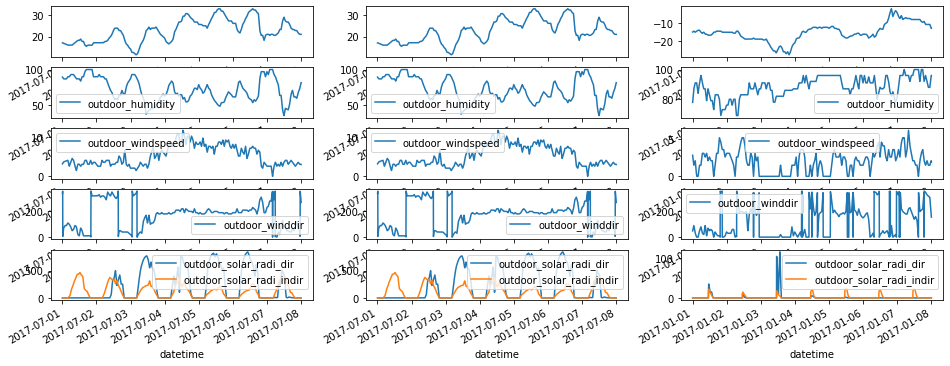

In [11]:
_, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,6))
vh.plot_sees(subdfs1, axes[:, 0])
vh.plot_sees(subdfs2, axes[:, 1])
vh.plot_sees(subdfs3, axes[:, 2])

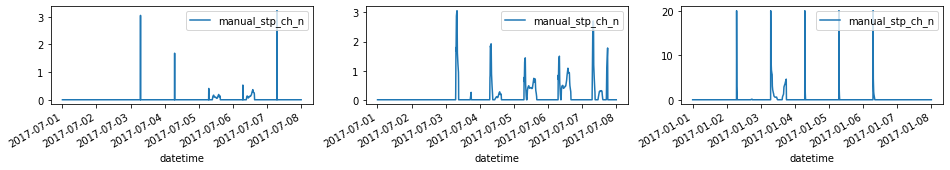

In [12]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,2))
vh.plot_eees_only_mstpc(subdfs1, axes[0])
vh.plot_eees_only_mstpc(subdfs2, axes[1])
vh.plot_eees_only_mstpc(subdfs3, axes[2])

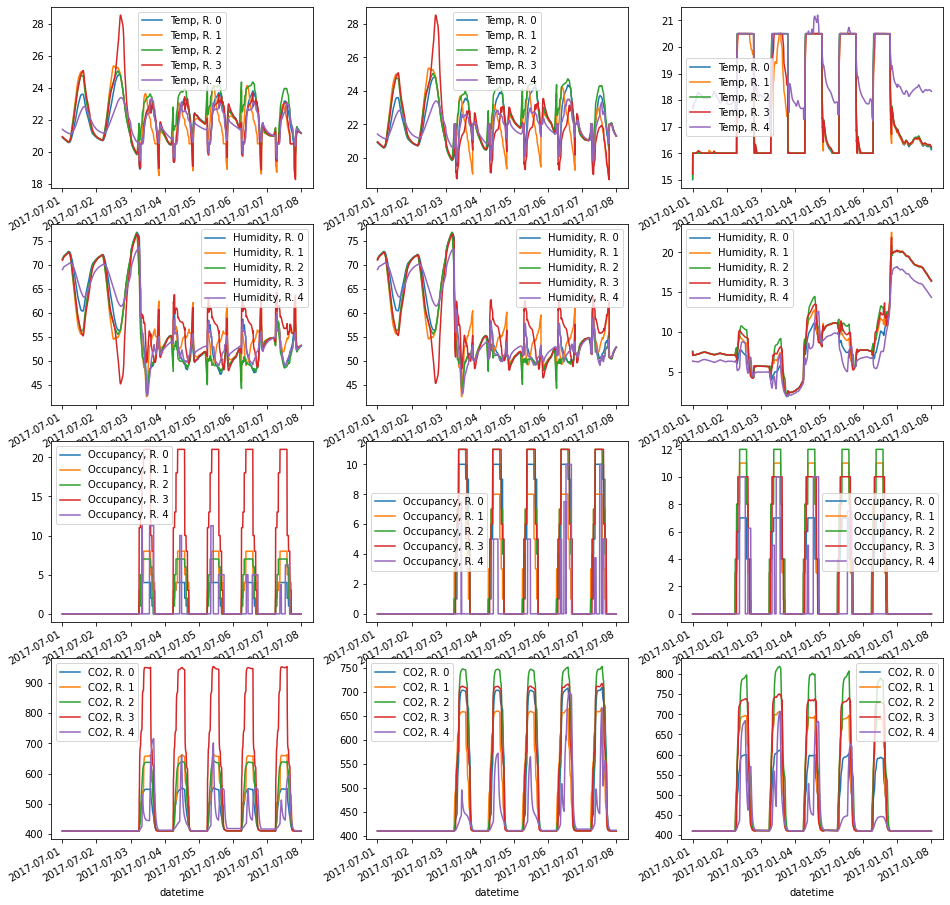

In [13]:
_, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,17))
vh.plot_seeser_all_rooms(subdfs1, axes[:, 0])
vh.plot_seeser_all_rooms(subdfs2, axes[:, 1])
vh.plot_seeser_all_rooms(subdfs3, axes[:, 2])
# for individual rooms use plot_seeser(subdfs, room_id, ax)

In [14]:
subdfs1_rooms  = subdfs1["seeser"].loc[:, "room"].unique()
subdfs1_agents = subdfs1["seesea"].loc[:, "agent_nr"].unique()
subdfs2_rooms  = subdfs2["seeser"].loc[:, "room"].unique()
subdfs2_agents = subdfs2["seesea"].loc[:, "agent_nr"].unique()
subdfs3_rooms  = subdfs3["seeser"].loc[:, "room"].unique()
subdfs3_agents = subdfs3["seesea"].loc[:, "agent_nr"].unique()
print("Available Room  IDs in subdfs1: ", subdfs1_rooms)
print("Available Agent IDs in subdfs1: ", subdfs1_agents)
print("Available Room  IDs in subdfs2: ", subdfs2_rooms)
print("Available Agent IDs in subdfs2: ", subdfs2_agents)
print("Available Room  IDs in subdfs2: ", subdfs3_rooms)
print("Available Agent IDs in subdfs2: ", subdfs3_agents)

Available Room  IDs in subdfs1:  [0 1 2 3 4]
Available Agent IDs in subdfs1:  [0 1 2 3 4]
Available Room  IDs in subdfs2:  [0 1 2 3 4]
Available Agent IDs in subdfs2:  [0 1 2 3 4]
Available Room  IDs in subdfs2:  [0 1 2 3 4]
Available Agent IDs in subdfs2:  [0 1 2 3 4]


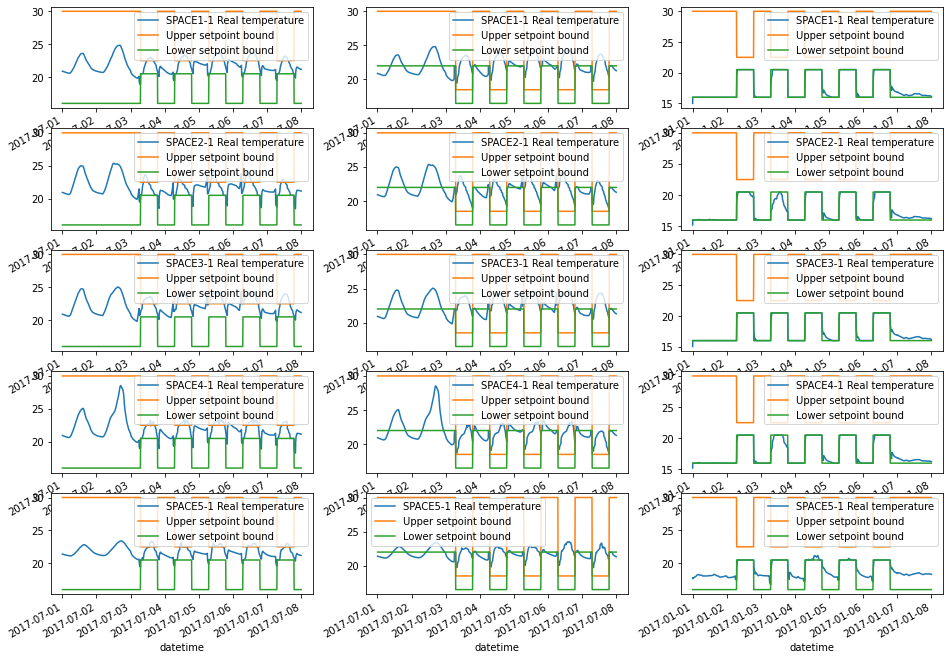

In [15]:
_, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,12))
for idx, roomid, agentid in zip(range(len(subdfs1_rooms)), subdfs1_rooms, subdfs1_agents):
    vh.plot_room_temp_agent_setpoint(subdfs1, roomid, roomid+1, agentid, axes[idx, 0])
for idx, roomid, agentid in zip(range(len(subdfs2_rooms)), subdfs2_rooms, subdfs2_agents):
    vh.plot_room_temp_agent_setpoint(subdfs2, roomid, roomid+1, agentid, axes[idx, 1])
for idx, roomid, agentid in zip(range(len(subdfs3_rooms)), subdfs3_rooms, subdfs3_agents):
    vh.plot_room_temp_agent_setpoint(subdfs3, roomid, roomid+1, agentid, axes[idx, 2])

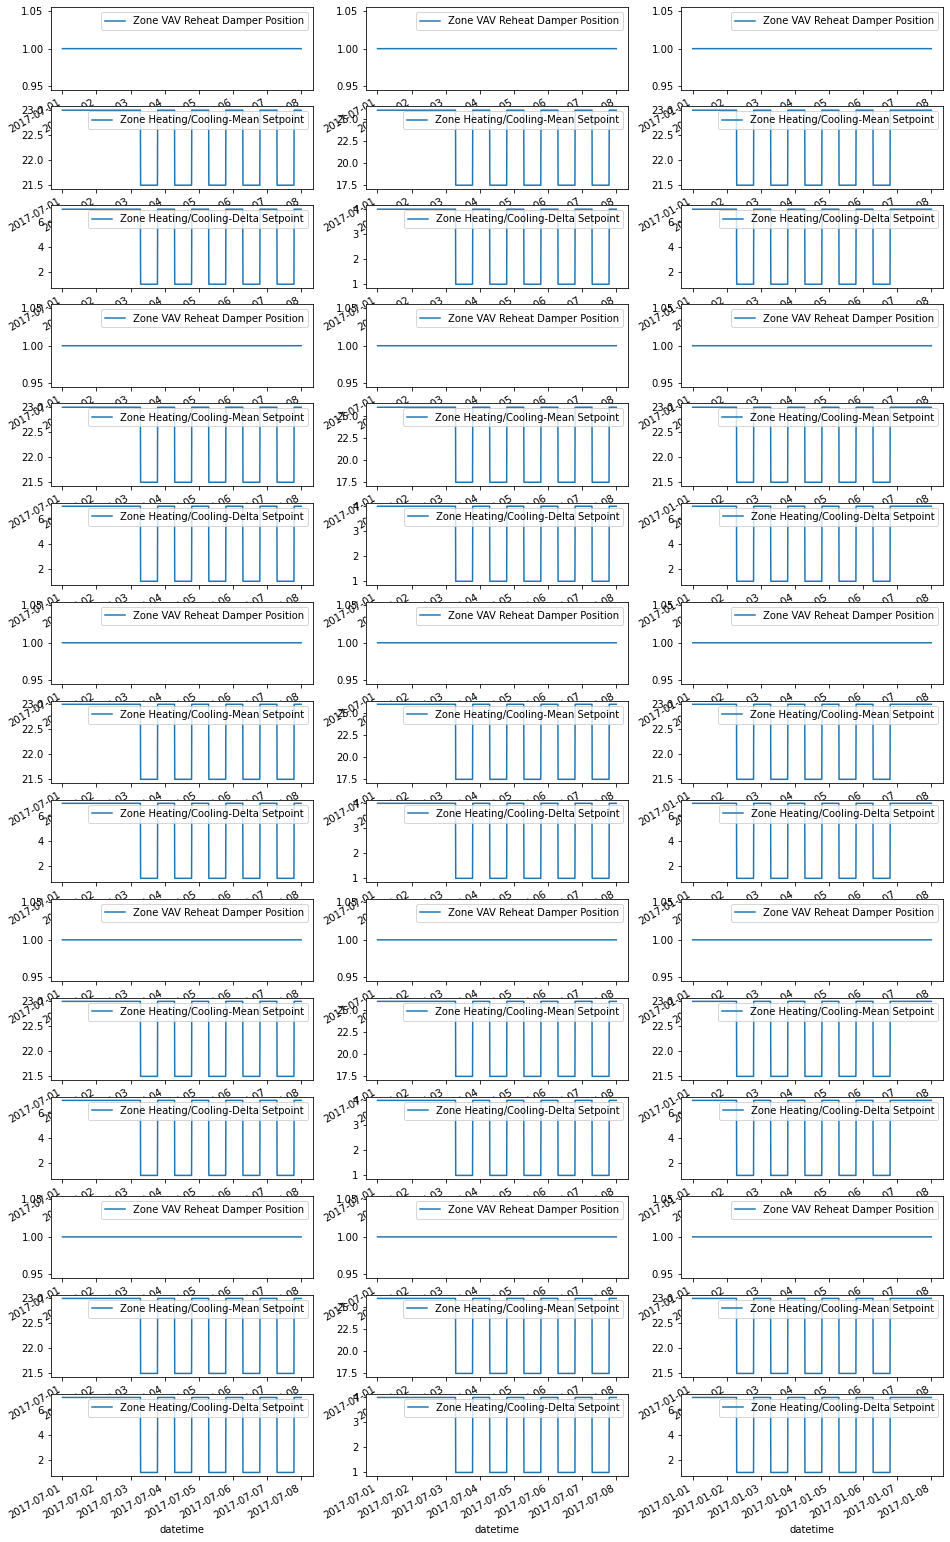

In [16]:
_, axes = plt.subplots(nrows=15, ncols=3, figsize=(16,30))
for a in axes.flatten():
    a.ticklabel_format(useOffset=False, style='plain')
vh.plot_seesea(subdfs1, axes[:, 0])
vh.plot_seesea(subdfs2, axes[:, 1])
vh.plot_seesea(subdfs3, axes[:, 2])

<h3>Details for a day</h3>

In [20]:
selected_episode     = 0
selected_periodA     = datetime.datetime(2017, 7, 3)
selected_periodA_end = datetime.datetime(2017, 7, 4)
selected_periodB     = datetime.datetime(2017, 1, 3)
selected_periodB_end = datetime.datetime(2017, 1, 4)

subdfs1 = vh.select_week_and_episode(dfs1, selected_episode, selected_periodA, selected_periodA_end)
subdfs2 = vh.select_week_and_episode(dfs2, selected_episode, selected_periodA, selected_periodA_end)
subdfs3 = vh.select_week_and_episode(dfs3, selected_episode, selected_periodB, selected_periodB_end)

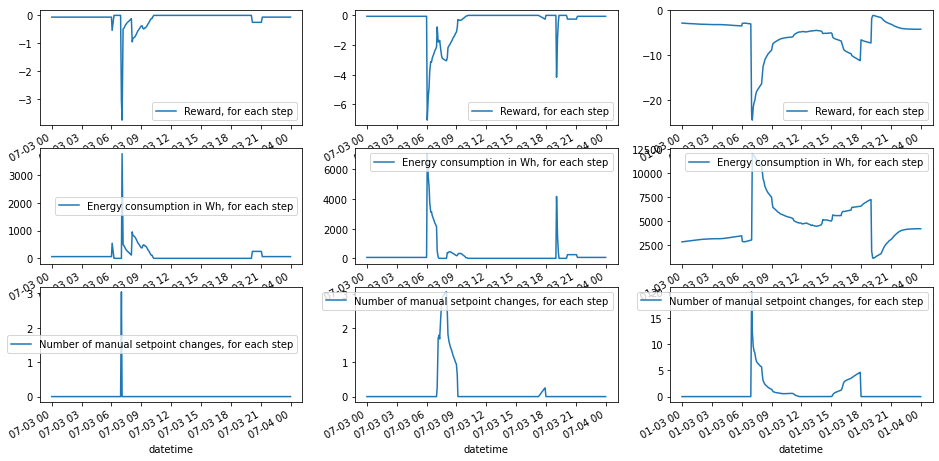

In [21]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,8))
vh.plot_eees_normal(subdfs1, axes[:, 0]) #['eees']['reward'].plot()
vh.plot_eees_normal(subdfs2, axes[:, 1])
vh.plot_eees_normal(subdfs3, axes[:, 2])

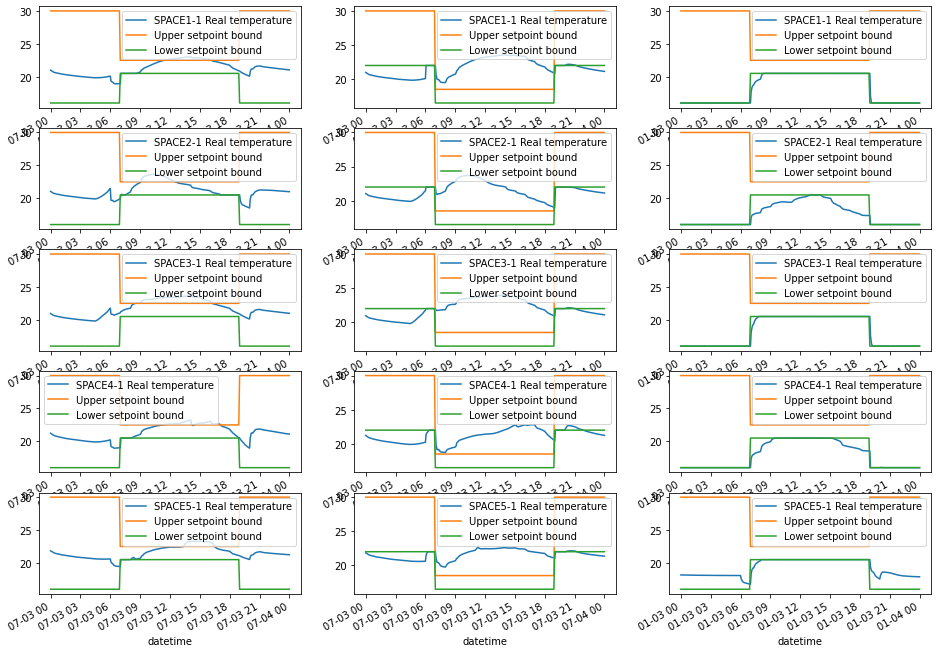

In [22]:
_, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,12))
for idx, roomid, agentid in zip(range(len(subdfs1_rooms)), subdfs1_rooms, subdfs1_agents):
    vh.plot_room_temp_agent_setpoint(subdfs1, roomid, roomid+1, agentid, axes[idx, 0])
for idx, roomid, agentid in zip(range(len(subdfs2_rooms)), subdfs2_rooms, subdfs2_agents):
    vh.plot_room_temp_agent_setpoint(subdfs2, roomid, roomid+1, agentid, axes[idx, 1])
for idx, roomid, agentid in zip(range(len(subdfs3_rooms)), subdfs3_rooms, subdfs3_agents):
    vh.plot_room_temp_agent_setpoint(subdfs3, roomid, roomid+1, agentid, axes[idx, 2])